<a href="https://colab.research.google.com/github/wilson428/EnlargeTheHouse/blob/main/EnlargeTheHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, Latex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import IntProgress

# What's the Optimal Size of the House?

---

As I explored in [this 2018 article in TIME](https://time.com/5423623/house-representatives-number-seats/), the House of Representatives is long overdue for an upgrade, having stood at 435 members for nearly 100 years as the population of the country has tripled. How much larger should it be to minimize the difference in how many people each Member represents?

At the time, based on figures from the 2010 decennial Census, I argued that it should be 930 seats, a magic number where the variance in people per representative reaches a local minimum. We now have figures for the 2020 Census and the [new apportionment](https://www.census.gov/data/tables/2020/dec/2020-apportionment-data.html) for the 435 seats. How does that figure change? 

To find out, let's run a computational experiment. The proof-of-concept for these functions, tested against the official Congressional tally, is available in the `Calculating_Apportionment.ipynb` file in this repo or on [Google CoLab](https://colab.research.google.com/drive/1-8L_NODTiCRNxVbFUgyzmiAn8ktMHF7Q?usp=sharing).

## Loading the Data

Congress reapportions the House every 10 years after the decennial Census figures are released. The [GitHub repo for this demo](https://github.com/TimeMagazineLabs/CongressionalApportionment) has data files from Census.gov for the 2010 and 2020 decennial Census counts as well as the official apportionments so that we can check our work. Here's what the data looks like:

In [2]:
dataByDecade = {}

for year in range(1910, 2021, 10):
  data = pd.read_csv('https://raw.githubusercontent.com/wilson428/EnlargeTheHouse/main/data/apportionment_%s.csv' % year, dtype={'State': 'string', 'Abbr': 'string', 'Reps': 'Int64'})
  data['Per_Rep'] = data['Population'] / data['Reps']
  dataByDecade['y' + str(year)] = data

In [3]:
dataByDecade['y2020'].head()

,State,Abbr,Year,Population,Reps,Per_Rep
0,Alabama,AL,2020,5030053,7,718579.000000
1,Alaska,AK,2020,736081,1,736081.000000
2,Arizona,AZ,2020,7158923,9,795435.888889
3,Arkansas,AR,2020,3013756,4,753439.000000
4,California,CA,2020,39576757,52,761091.480769


As we can easily see, the number of people represented by each Member of Congress has ballooned drastically in the past 100 years 

In [4]:
reps1920 = dataByDecade['y1920'][dataByDecade['y1920']['Reps'] > 0]
reps2020 = dataByDecade['y2020'][dataByDecade['y2020']['Reps'] > 0]

print('In 1920, the %s House Members for %d states represented between %s and %s people' % (
  sum(reps1920['Reps']), reps1920.shape[0], '{0:,}'.format(int(min(reps1920['Per_Rep']))), '{0:,}'.format(int(max(reps1920['Per_Rep'])))
))

print('In 2020, the %s House Members for %d states represented between %s and %s people' % (
  sum(reps2020['Reps']), reps2020.shape[0], '{0:,}'.format(int(min(reps2020['Per_Rep']))), '{0:,}'.format(int(max(reps2020['Per_Rep'])))
))

In 1920, the 435 House Members for 48 states represented between 77,407 and 360,350 people
In 2020, the 435 House Members for 50 states represented between 542,703 and 990,837 people


## How Apportionment Works: The Equal Proportions Method

Since 1940, Congress [has used the "Equal Proportions Method"](https://www.census.gov/topics/public-sector/congressional-apportionment/about/computing.html) to apportion the 435 House seats to each state—a figure that is enshired by law, not by mathematics or logic.

First, per the Constitution, every state gets one seat. For the remaining 385, each state's "priority" is measured by a simple formula that divides its population, as of the most recent decennial Census, by the square root of the product of the number of seats it currently has and that number plus 1 (the [geometric mean](https://mathworld.wolfram.com/GeometricMean.html)):
\begin{equation}
priority = \frac{P}{\sqrt{n*(n+1)}}
\end{equation}
For each seat, one at a time, the state with the highest priority is awarded another representative. Its priority is then recalculated and it moves further back in line. Let's write a Python function to calculate the priority of a state, representated as a row in the table (aka "DataFrame") above. (We'll be adding a `RepsCalculated` column to compare to the official tally.)

In [5]:
def EqualProportionsMethod(st):
  reps = st["RepsCalculated"]
  priority = st["Population"] / np.sqrt(reps * (reps + 1))
  return priority

## Recalculating the apportionments

As covered in detail in the [previous Notebook](https://colab.research.google.com/drive/1-8L_NODTiCRNxVbFUgyzmiAn8ktMHF7Q?usp=sharing), we can now write a function to apportion any number of seats we like:

In [6]:
def addNextSeat(df, ORDER=[]):
  indexNext = df['Priority'].idxmax() # The index of the row with the highest priority
  # Add a seat to the state in that row
  df.loc[indexNext,'RepsCalculated'] += 1
  # Recompute the priority for this state
  df.loc[indexNext,'Priority'] = EqualProportionsMethod(df.loc[indexNext])
  # Add the state to the ORDER list
  ORDER.append(df.loc[indexNext,'Abbr'])

def calculateApportionment(popData=dataByDecade['y2020'], ignoreStates=['District of Columbia', 'Puerto Rico'], TOTAL_SEATS=435):
  ORDER_SEATS = []

  data_filtered = popData[~popData['State'].isin(ignoreStates)]
  data_filtered.reset_index(drop=True)

  test_apportionment = data_filtered.copy()
  test_apportionment['RepsCalculated'] = 1
  test_apportionment["Priority"] = test_apportionment.apply(EqualProportionsMethod, 1)

  SEATS_LEFT = TOTAL_SEATS - test_apportionment.shape[0] # This is the number of rows, which will account for any hypothetical states we add
  while SEATS_LEFT > 0:
    addNextSeat(test_apportionment, ORDER_SEATS)
    SEATS_LEFT -= 1

  test_apportionment['Per_RepCalculated'] = test_apportionment['Population'] / test_apportionment['RepsCalculated']

  return test_apportionment, ORDER_SEATS 

In [7]:
test_2020, order_2020 = calculateApportionment()
test_2020.head()

,State,Abbr,Year,Population,Reps,Per_Rep,RepsCalculated,Priority,Per_RepCalculated
0,Alabama,AL,2020,5030053,7,718579.000000,7,672169.105833,718579.000000
1,Alaska,AK,2020,736081,1,736081.000000,1,520487.866603,736081.000000
2,Arizona,AZ,2020,7158923,9,795435.888889,9,754616.742459,795435.888889
3,Arkansas,AR,2020,3013756,4,753439.000000,4,673896.328360,753439.000000
4,California,CA,2020,39576757,52,761091.480769,52,753877.180693,761091.480769


Just to reiterate from the previous workbook, this matches the official apportionment, which the final seat going to Minnesota:

In [8]:
error = np.abs(test_2020['Reps'] - test_2020['RepsCalculated'])
print('Total difference from actual apportionment: %d' % max(error))
print('Final seat went to %s' % order_2020[-1])

Total difference from actual apportionment: 0
Final seat went to MN


Since we'll be measuring success based on the difference between how well states are represented, let's see what these values actually look like:

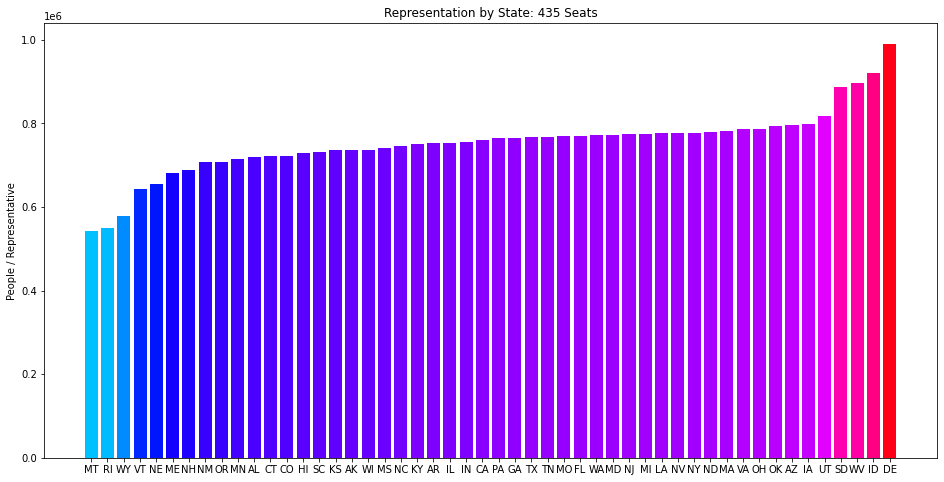

In [9]:
def plotResults(apportionment):
  df = apportionment.copy().sort_values('Per_RepCalculated')
  y = df['Per_RepCalculated']
  colors = cm.hsv(y / max(y))
  fig = plt.figure(figsize=(16, 8), frameon=True);
  plt.title("Representation by State: 435 Seats")
  plt.ylabel('People / Representative')
  ax = fig.gca();
  ax.bar(df['Abbr'],y,color=colors)

plotResults(test_2020)

# Scoring the Results

So how well does the current apportionment represent every American equally? In my original experiment, I used the coefficient of variation as a meter of success. One great way to "score" the results is the ["Coefficient of Variation,"](https://www.investopedia.com/terms/c/coefficientofvariation.asp) a simple statistical method of normalizing the standard deviation by dividing it by the average value. (We could also use a simple range from the lowest to highest values or the ["Average Squared Deviation"](https://people.richland.edu/james/lecture/m113/variation.html) in future research.)

In [10]:
def SCORE_coeff_of_variance(vals):
  return np.std(vals) / np.mean(vals)

SCORE_coeff_of_variance(test_2020['Per_Rep'])

0.10299165948743454

Using the coefficient of variance, the current score is about 0.1, which might be better with more seats. Since we made the number of seats a variable, let's see if it improves if we add 25 seats:

In [11]:
test_460, order_460 = calculateApportionment(TOTAL_SEATS=460)
print(order_460[-1])
SCORE_coeff_of_variance(test_460['Per_RepCalculated'])

MO


0.09990156250807743

Yep, a House of Representatives of 460 seats would have a lower variance in how equally each American is represented, with the last seat going to Missouri. Is there an optimal number? Let's just try every value from 435 to 1,305, three times that.

While we could run the `calculateApportionment` function 970 times, this will take around 10 minutes--believe me, I tried! But that would be wasteful, because each iteration is recomputing the same order of seats and just adding another. So we can save a lot of time by running this once, for 1,035 seats, and then applying the order to however many seats we want, like so:

In [12]:
apportionment_1305, ORDER_1305 = calculateApportionment(TOTAL_SEATS=435*3)

Now we just need a function to take a subset of that grand order, up to however many seats we want, and dole them out:

In [13]:
def computeSeats(popData=dataByDecade['y2020'], ignoreStates=['District of Columbia', 'Puerto Rico'], TOTAL_SEATS=435):

  # Make a copy of the population dataframe, then join them
  data_filtered = popData[~popData['State'].isin(ignoreStates)]
  data_filtered.reset_index(drop=True)

  # Remember to subtract the number of states from the total we apportion one automatically
  orderX = ORDER_1305[:TOTAL_SEATS - len(data_filtered)]

  # Here's a little trick: Assuming that every state gets at least one seat in the 1,305 scenario, we can use `set` to reduce to unique abbreviations:
  abbrs = set(ORDER_1305)
  # print(len(abbrs)) # will be 50

  # Here's another neat trick for tallying the number of duplicate items in a list
  # h/t https://stackoverflow.com/questions/42317134/how-to-get-a-tally-of-each-letter-in-a-string
  # This will assign 1 to each state even if it never shows up in the order (e.g. AK in the 435 scenario)
  seats = { st: 1 + orderX.count(st) for st in abbrs }

  # convert the dictionary to a list of tuples
  seats = [ (st,reps) for st,reps in seats.items() ]

  # then convert it to a dataframe
  df = pd.DataFrame(seats, columns = ['Abbr', 'RepsCalculated'])
  df = df.astype({ 'Abbr': 'string', 'RepsCalculated': 'Int64' })

  apportionmentX = data_filtered.copy()
  apportionmentX = apportionmentX.set_index("Abbr").join(df.set_index("Abbr"))
  apportionmentX['Per_RepCalculated'] = apportionmentX['Population'] / apportionmentX['RepsCalculated']

  # print(len(orderX), len(ORDER_1035))
  return apportionmentX, orderX

Again, let's run a sanity test to make sure this method computes correctly for the real apportionment

In [14]:
test_2020B, order_2020B = computeSeats(TOTAL_SEATS=435)
test_2020B.head()

error = np.abs(test_2020B['Reps'] - test_2020B['RepsCalculated'])
print('Total difference from actual apportionment: %d' % max(error))
print('Final seat went to %s' % order_2020B[-1])

Total difference from actual apportionment: 0
Final seat went to MN


Once again, looks good! Let's try it for all sizes:

In [15]:
SIZES = list(range(435,435*3))
TRIALS = []

progressBar = IntProgress(min=435, max=435*3) # instantiate the bar
display(progressBar) # display the bar

for s in SIZES:
  apportionmentN, orderN = computeSeats(TOTAL_SEATS=s)
  TRIALS.append({
      'size': s,
      'apportionment': apportionmentN,
      'order': orderN,
      'score': SCORE_coeff_of_variance(apportionmentN['Per_RepCalculated'])
  })
  progressBar.value += 1

IntProgress(value=435, max=1305, min=435)

Trust me, that went WAY faster than reculating the apportionment from scratch every time. How did we do? Let's plot the scores for all three scoring methods.

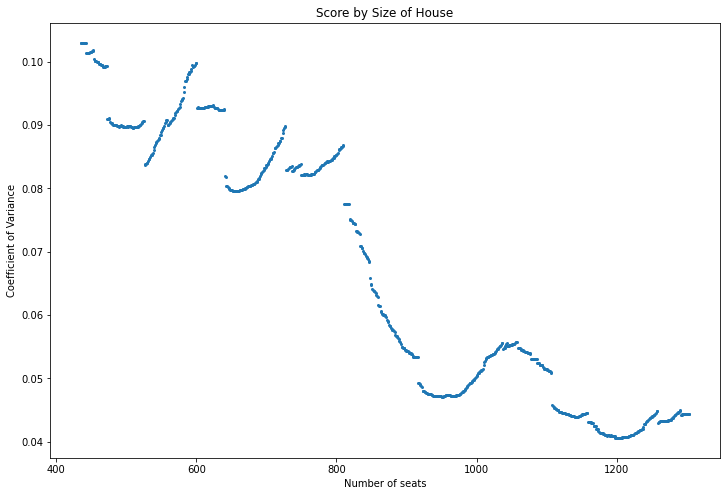

In [16]:
def plotScores():
  SCORES = [x['score'] for x in TRIALS]
  fig = plt.figure(figsize=(12, 8), frameon=True);
  plt.title('Score by Size of House')
  plt.xlabel('Number of seats')
  plt.ylabel('Coefficient of Variance')
  ax = fig.gca();
  ax.plot(SIZES, SCORES, 'o', markersize=2)

plotScores()

This is curious! While the variation, or "score," goes down generally as the size of the House increases, as we'd expect, there are clearly ideal values, as we saw last time [I ran this experiment](https://time.com/5423623/house-representatives-number-seats/). Let's identify and plot them:

Lowest values after drop:
     size     score     delta
673  1108  0.045743 -0.005190
482   917  0.049247 -0.004085
413   848  0.065905 -0.002544
384   819  0.075262 -0.002355
376   811  0.077571 -0.009300


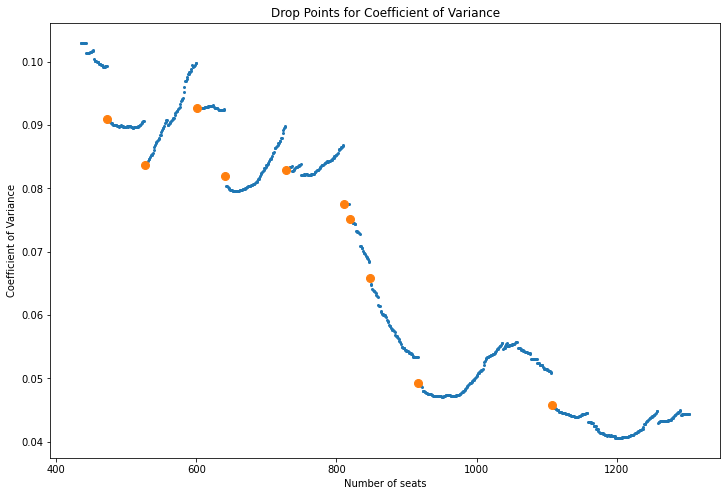

In [17]:
def calculateDropPoints():

  SCORES = [x['score'] for x in TRIALS]

  results = pd.DataFrame({
    'size': SIZES,
    'score': SCORES
  })

  # calculate the drop from the previous value, and reduce to the 10 largest drops, then resort by score
  results['delta'] = results.score -  results.score.shift(1)
  idealValues = results.sort_values('delta').head(10).sort_values('score')
  print('Lowest values after drop:')
  print(idealValues.head(5))

  dropPoints = list(idealValues['size'][:])
  dropValues = list(idealValues['score'][:])

  fig = plt.figure(figsize=(12, 8), frameon=True);
  plt.title("Drop Points for Coefficient of Variance")
  plt.xlabel('Number of seats')
  plt.ylabel('Coefficient of Variance')
  ax = fig.gca();
  ax.plot(SIZES, SCORES, 'o', markersize=2)
  ax.plot(dropPoints, dropValues, 'o', markersize=8)

  return(dropPoints)

topDropPoints = calculateDropPoints()

## What's Causing the Drops?

Let's see if there are any interesting properties in these magic values, like the minimum and maximum number of reps per state and the mean number of people per representative, as well as who got the last seat and the smallest number of seats:

In [18]:
testPoints = [x for x in TRIALS if x['size'] in topDropPoints]
SCENARIOS = []

for trial in testPoints:
  vals = trial['apportionment']['Per_RepCalculated']
  seats = trial['apportionment']['RepsCalculated'].tolist()

  SCENARIOS.append({
    'size': trial['size'],
    'score': trial['score'],
    'perRepMin': min(vals),
    'perRepMax': max(vals),
    'perRepMean': np.mean(vals),
    'minSeats': min(seats),
    'statesWithMinimumSeats': seats.count(min(seats)),
    'lastSeat': trial['order'][-1]
  })

In [19]:
df = pd.DataFrame.from_dict(SCENARIOS)
df.sort_values('size')
df

,size,score,perRepMin,perRepMax,perRepMean,minSeats,statesWithMinimumSeats,lastSeat
0,473,0.091049,495418.500000,887770.000000,692717.863082,1,5,DE
1,526,0.083756,443885.000000,779702.000000,629202.604718,1,4,SD
2,601,0.092744,389851.000000,736081.000000,549025.108946,1,3,ND
3,641,0.081955,368040.500000,643503.000000,511273.805858,1,2,AK
4,728,0.082856,321751.500000,577719.000000,456041.125297,1,1,VT
5,811,0.077571,288859.500000,495418.500000,405550.329794,2,6,WY
6,819,0.075262,288859.500000,459696.333333,400053.037279,2,5,DE
7,848,0.065905,288859.500000,443885.000000,383700.929714,2,5,ME
8,917,0.049247,288859.500000,392666.600000,358310.239965,2,4,SD
9,1108,0.045743,245360.333333,330279.000000,295759.126984,2,2,AK


As we see, there are many optimal values that get increasingly more equal as the size grows. **The value 917 has a dramatic drop to a covariance below .05**, and increasing the size beyong that doesn't improve the score that much.

But if that's too big a House for your liking, even 473 is a huge improvement. And 811 is a notable figure since it's the first value that organically assigns at least 2 representatives to each state.

# Next Up:

What if there's a better algorithm than the Equal Proportions Method? Or a better way to measure the results than the coefficient of variance? The above code is sufficiently modular that you can clone this repo or notebook and substitute in any function you like. If you find something interesting, please e-mail me at chris.wilson@time.com. Good luck&mdash;the future of democracy is in your hands!